# Tutorial: Visibility Graphs

The objective of this tutorial is to introduce the network-based method of visibility graphs for nonlinear time series analysis, and to illustrate its implementation in the `pyunicorn` package. First some theoretical background for understanding visibility graphs will be given, and then some of the methods in `timeseries.VisibilityGraph` will be highlighted. For a detailed discussion and further references, please consult __[Donges et al. (2015)](https://aip.scitation.org/doi/10.1063/1.4934554)__, on which this tutorial is based.

## Introduction

_Visibility Graphs (VG)_ encode visibility relations between data points in the one-dimensional time domain, by drawing upon analogies between height profiles in physical space and the profile of a time series graph. More precisely, VGs are based on the existence or non-existence of lines of sight between well-defined objects (__[Donges et al., 2015](https://aip.scitation.org/doi/10.1063/1.4934554)__).
They can be applied to investigate purely temporal features such as long-range correlations (__[Lacasa et al., 2009](https://iopscience.iop.org/article/10.1209/0295-5075/86/30001)__) or time reversal asymmetry (__[Donges et al., 2013](https://iopscience.iop.org/article/10.1209/0295-5075/102/10004)__).

## Theory of Time Series Visibility Graphs (VGs)

### Standard VG

In a time series context, well-defined objects between which lines of sight can be established are the sampling points of a (univariate) time series graph. These sampling points are uniquely characterised by pairs $(t_v, x_v)$ with $x_v = x(t_v)$. From a practical perspective, we can identify each node $v$ of a standard visibility graph with a given time point $t_v$. For $t_v < t_p$ (and, hence, $v < p$) a link between the nodes $v$ and $p$ exists iff

$$\forall\; q \in (v,p):\quad x_q < x_v + \frac{x_p-x_v}{t_p-t_v}(t_q - t_v)\,.$$

Put differently, the topological properties of VGs take into account the time-ordering of observations explicitly and are thus closely related to the roughness of the underlying time series profile. An illustration of a timeseries with respective visibility relations (grey lines) can be seen in the figure below, taken from __[Donner and Donges (2012)](https://link.springer.com/article/10.2478/s11600-012-0032-x)__. The VG of a time series stays invariant under arbitrary affine transformations.

![visibilitygraph](images/SimpleVG.png)

### Horizontal VG

A notable algorithmic variant are _horizontal visibility graphs (HVGs)_ that facilitate analytical investigations of graph profiles (__[Luque et al., 2009](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.046103)__). For HVGs, the more restrictive condition

$$\forall\;q\in(v,p):\quad x_q<\text{min}\{x_v,x_p\}$$

is used and the linkset of a HVG is a subset of that of a standard VG. A HVG remains invariant only for uniform translations and rescaling of the original data.
An illustrative example of a HVG can be seen in the figure below, taken from __[Luque et al. (2009)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.046103)__. In the upper part a time series is plotted with the respective horizontal visibility relations (arrowed lines), and in the lower part the resulting mapping to a HVG can be seen.

![horizontalvisibilitygraph](images/HVG.png)

### Testing Time Series Irreversibility

By decomposing degrees and local clustering coefficients for VGs and HVGs into contributions from past and future observations, statistical properties under time-reversal of time series can be analysed. Statistically significant deviations are often found between the distributions of time-directed vertex properties for non-linear systems that are known to be time-irreversible, but not for linear systems (__[Donges et al., 2013](https://iopscience.iop.org/article/10.1209/0295-5075/102/10004)__).

#### Time-Directed Vertex Properties

To account for the fact that the time-ordering of data is intrinsically interwoven with the resulting network structure of VGs and HVGs, a set of statistical network quantifiers can be defined, based on two simple vertex (node) characteristics:

- Decomposing the degree $k_v$ of a vertex $v$, i.e., the number of edges incident to it, into contributions due to other vertices in the past and future of $t_v$, one obtains the time-retarded ($k_v^r$) and the time-advanced ($k_v^a$) degree:
$$k_v^r = \sum_{p\in V:\,p<v}A_{vp} \,,\qquad k_v^a = \sum_{p\in V:\,p>v}A_{vp}\,.$$

- In a similar manner, the local clustering coefficient $C_v$, which characterises the likelihood that the neighbours of $v$ are also connected, can be expressed in terms of past and future contributions:
$$C_v^r = \left( _{2}^{k_v^r} \right)^{-1}\!\! \sum_{p,q\in V:p,q<v}A_{vp}A_{pq}A_{qv} \,,\qquad C_v^a = \left( _{2}^{k_v^a} \right)^{-1} \!\!\sum_{p,q\in V:p,q>v}A_{vp}A_{pq}A_{qv} \,.$$

#### Irreversibility Test via Kolmogorov-Smirnov (KS)

Looking at the frequency distributions of the retarded and advanced sequences for one vertex characteristic,
in case of time reversibility it is expected that they should be drawn from the same probability distributions, e.g., $p(k_v^r) \approx p(k_v^a)$. Thus, rejecting the null hypothesis that  $\{k_v^r\}_v$ and $\{k_v^a\}_v$ (or $\{C_v^r\}_v$ and $\{C_v^a\}_v$) are drawn from the same probability distribution, respectively, is equivalent to rejecting the null hypothesis that the time series is reversible.

For sufficiently long time series, the samples of individual vertex properties approximate the underlying distributions sufficiently well, and the Kolmogorov-Smirnov (KS) test can be used to check this hypothesis. Specifically, a small $p$-value of the KS test statistic (e.g., $p<0.05$) implies that the time series has likely been generated by an irreversible process.
For illustration purposes, the distributions of time-directed vertex properties of a linear and a non-linear timeseries will be analysed in the following.

## Application of VGs

As an example for the application of VGs and HVGs and of the class `VisibilityGraph`, a linear and a non-linear time series will be tested first visually, and then with the KS test for irreversibility.

### First Steps

In [1]:
import math

import numpy as np
from matplotlib import pyplot as plt
from pyunicorn.timeseries import VisibilityGraph

#### Synthetic Data

First, we create and plot a linear time series, based on a linear-stochastic first-order autoregressive model (*AR(1)*) with an additive Gaussian noise term:
$$x_t = \alpha x_{t-1} + \xi_t \,,$$ 
where $\alpha = 0.5$.
For more background on the construction of time series, consult __[Shumway and Stoffer (2017)](https://link.springer.com/book/10.1007/978-3-319-52452-8)__. 

In [2]:
# we set a seed to reproduce results later
np.random.seed(42)
# process parameters
a = 0.5
mu, sigma = 0, 1
# sample size
N = 5000
# Gaussian noise
x_t = np.random.normal(mu, sigma, N)
# AR(1)
w_t = np.zeros(N)
t = np.arange(0, N, 1)
for i in t[1:]:
    w_t[i] = a*w_t[i-1] + x_t[i]

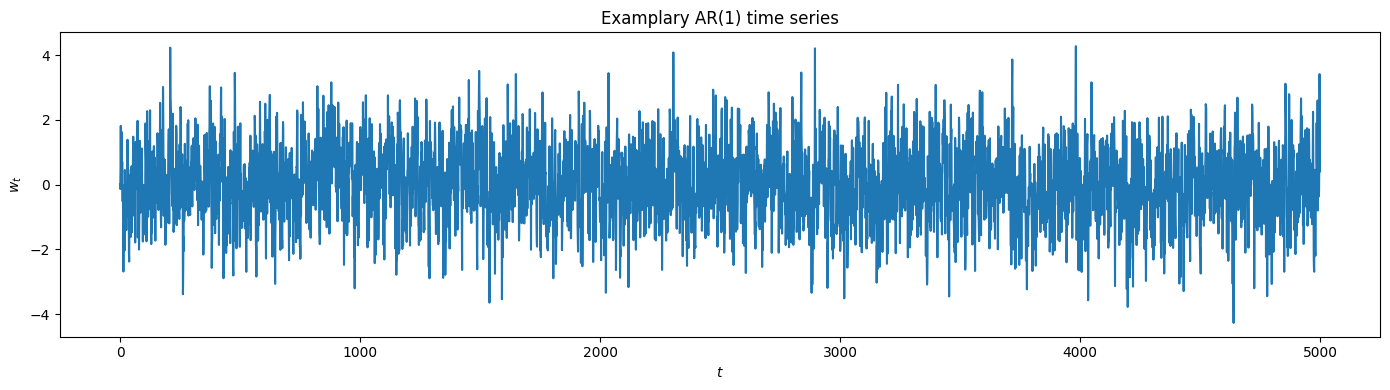

In [3]:
plt.figure(figsize=(14, 4), tight_layout=True)
plt.plot(t, w_t)
plt.xlabel("$t$"); plt.ylabel("$w_t$")
plt.title("Examplary AR(1) time series");

#### Visibility Relations

Now we construct a `VisibilityGraph` instance. Note the keyword `horizontal`, which is `False` by default.

In [4]:
VG1 = VisibilityGraph(w_t, horizontal=False)
print(VG1)

Calculating visibility relations...
VisibilityGraph: time series shape (5000,).
InteractingNetworks:
Network: undirected, 5000 nodes, 16703 links, link density 0.001.


In [5]:
HVG1 = VisibilityGraph(w_t, horizontal=True)
print(HVG1)

Calculating horizontal visibility relations...


VisibilityGraph: time series shape (5000,).
InteractingNetworks:
Network: undirected, 5000 nodes, 9986 links, link density 0.001.


It can be illustrative to plot the visibility relations via the method `VisibilityGraph.visibility_relations()`. Note that here we zoom in along the time axis.

Calculating visibility relations...


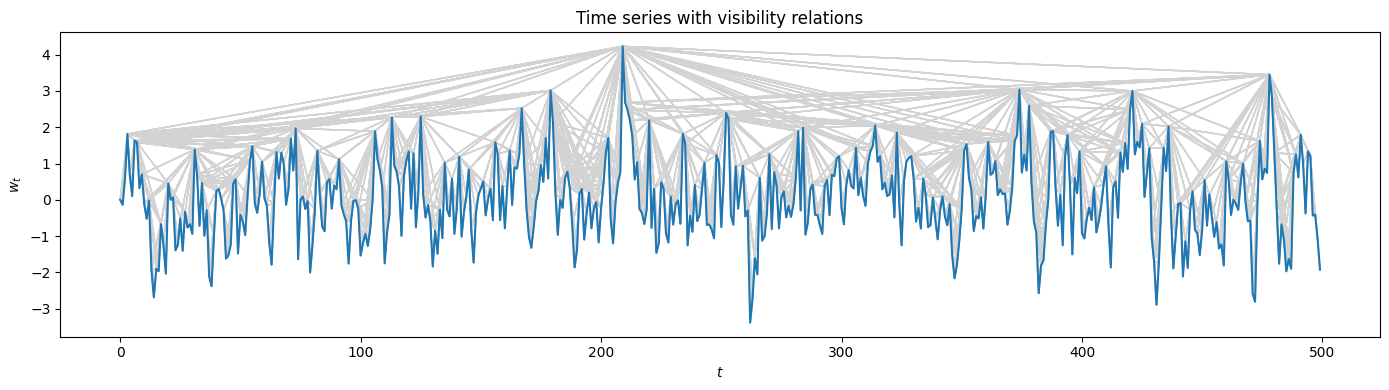

In [6]:
# obtain the visibilty relations as a Boolean mask
visibility_relations = VG1.visibility_relations()
# zoom
cutoff = int(N/10)

# plotting the visibilty relations as grey arrows
plt.figure(figsize=(14, 4), tight_layout=True)
plt.plot(t[:cutoff], w_t[:cutoff])
plt.xlabel("$t$"); plt.ylabel("$w_t$")
plt.title("Time series with visibility relations")
for i in range(cutoff):
    for k in range(cutoff):
        if visibility_relations[i][k]:
            plt.arrow(i, w_t[i], (k-i), (w_t[k]-w_t[i]), color='lightgrey')

Of course, we can also plot the visibility relations for the HVG using `VisibilityGraph.visibility_relations_horizontal()`. In this case, only the visibility lines for one specific node are plotted as an example, albeit not horizontally.

Calculating horizontal visibility relations...


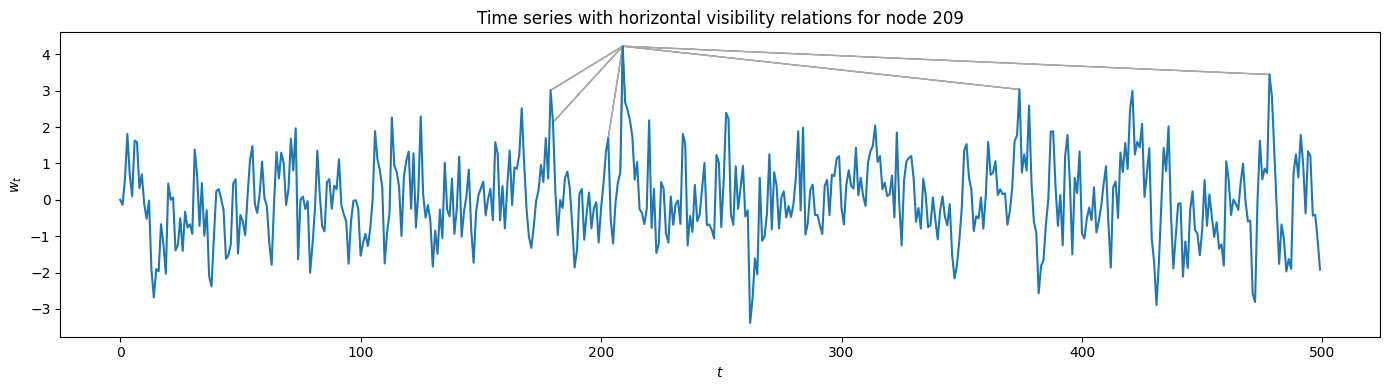

In [7]:
visibility_relations_horizontal = HVG1.visibility_relations_horizontal()

i = 209 # only plot the nodes visible from here
plt.figure(figsize=(14, 4), tight_layout=True)
plt.plot(t[:cutoff], w_t[:cutoff]) # zooming in a bit
plt.xlabel("$t$"); plt.ylabel("$w_t$")
plt.title(f"Time series with horizontal visibility relations for node {i}")
for k in range(cutoff):
    if visibility_relations_horizontal[i][k]:
        ax = plt.arrow(i, w_t[i], k-i, w_t[k]-w_t[i], color='darkgray')

### Irreversibility Test

#### Linear Time Series

We start by analysing the linear time series via its time directed degrees:

In [8]:
k_r1 = VG1.retarded_degree()
k_a1 = VG1.advanced_degree()

Applied to a VG, both methods return an array with the corresponding degree for each node. For such an array, we can obtain the probability for each degree with a kernel-density estimate using Gaussian kernels. [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) is a way to estimate the probability density function (PDF) of a random variable in a non-parametric way. We use `scipy.stats.gaussian_kde` for that.

In [9]:
from scipy.stats import gaussian_kde 
gkde_r1 = gaussian_kde(k_r1)
gkde_a1 = gaussian_kde(k_a1)

Now we plot $p(k_v^r)$ against $k_v^r$ in red, and $p(k_v^a)$ against $k_v^a$ in black, and compare both visually. The y-scale is linear in the first figure and logartihmic in the second. Both plots are cut off at a degree of 12, at which the empirical frequencies become too low to be comparable.

In [10]:
def plot_time_directed(r, a, ylog=False):
    plt.figure(figsize=(14, 3), tight_layout=True)
    x = np.linspace(0, 12, 1000)
    plt.plot(x, r.evaluate(x), color="red", label="retarded")
    plt.plot(x, a.evaluate(x), color="black", label="advanced")
    plt.xlabel("$k$"); plt.ylabel("$p(k)$")
    if ylog:
        plt.yscale("log")
    plt.legend()

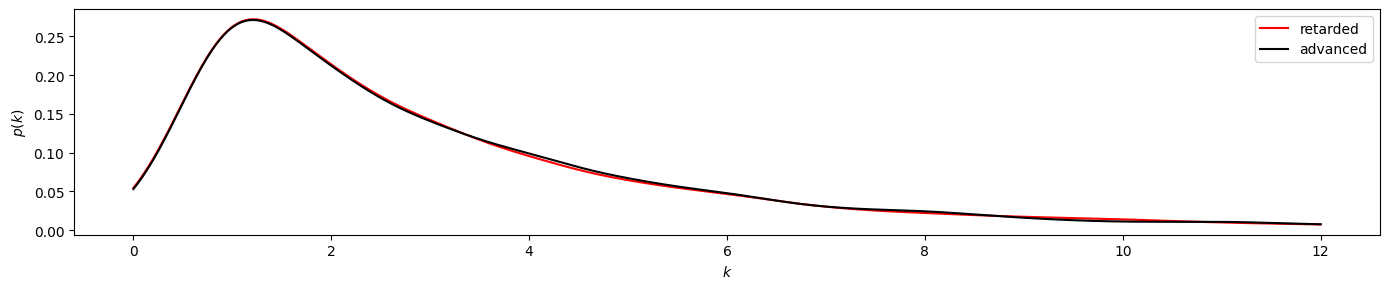

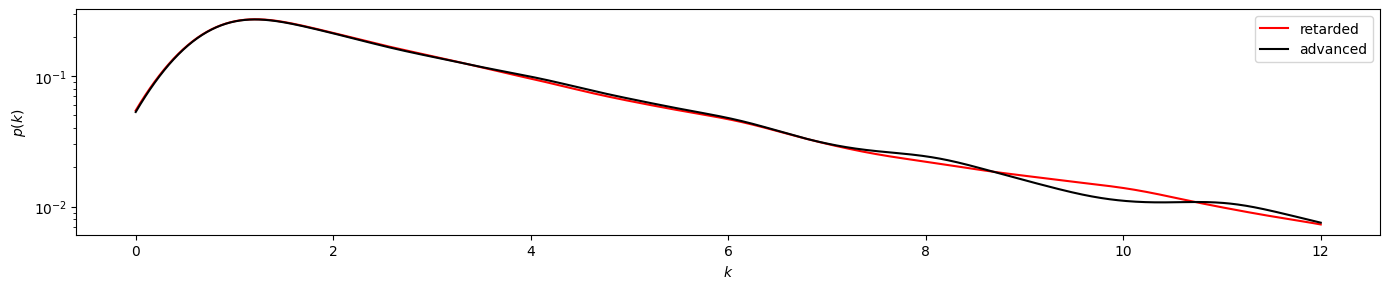

In [11]:
plot_time_directed(gkde_r1, gkde_a1)
plot_time_directed(gkde_r1, gkde_a1, ylog=True)

By visual investigation we already find strong similarities between the distributions. Now we also apply the KS test for this time series, using `scipy.stats.ks_2samp` to obtain the $p$-value of the two input data sets.

In [12]:
from scipy.stats import ks_2samp
ks_2samp(k_r1, k_a1)

KstestResult(statistic=0.0072, pvalue=0.9994903068538411, statistic_location=3.0, statistic_sign=1)

The result of `pvalue=0.999... > 0.05` indicates that the time series has likely been generated by a reversible process.

#### Non-Linear Time Series

Now we will perform the same procedure for a non-linear time series. We can construct one using the logistic map for instance, which we take from the tutorial on recurrence networks. We only change the bifurcation parameter ($r = 4$) to find ourselves deeply in the chaotic regime.

In [13]:
def logistic_map(x0: float, r: float, T: int, spinup: int = 100):
    """
    Returns a time series of length T using the logistic map
    x_(n+1) = r*x_n(1-x_n)
    at parameter r and using the initial condition x0.

    INPUT: x0 - Initial condition, 0 <= x0 <= 1
            r - Bifurcation parameter, 0 <= r <= 4
            T - length of the desired time series
            spinup - number of spinup-timesteps before storing results to output
    OUTPUT: numpy array of timeseries under given parameters
    """
    # spinup
    for n in range(spinup):
        x0 = r * x0 * (1 - x0)

    timeseries = np.zeros(T + 1)
    timeseries[0] = x0
    for n in range(T):
        # get current timestep value
        xn = timeseries[n]
        # calculate next timestep value
        xstep = r * xn * (1 - xn)
        timeseries[n + 1] = xstep
    return timeseries

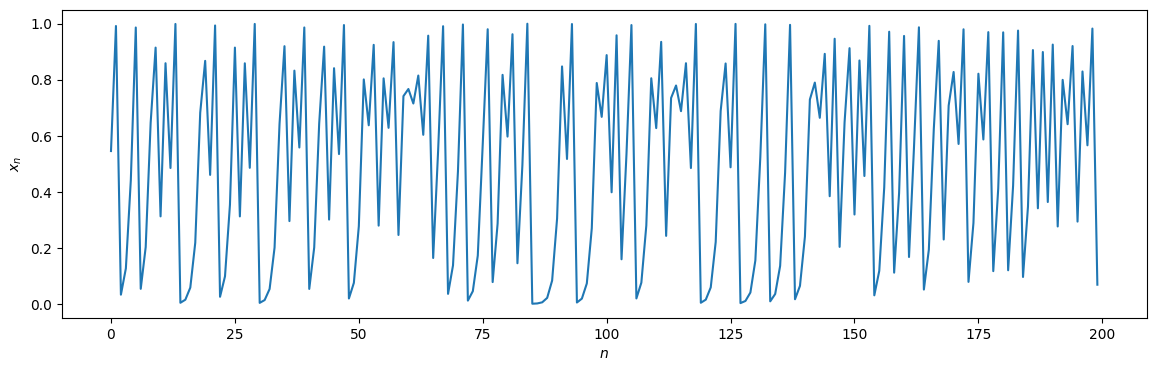

In [14]:
r = 4
x0 = 0.8
T = 5000
time_series = logistic_map(x0, r, T)

cutoff = 200
plt.figure(figsize=(14, 4))
plt.plot(time_series[:cutoff])
plt.xlabel("$n$"); plt.ylabel("$x_n$");

We again compare the time-directed degree distributions visually:

In [15]:
VG2 = VisibilityGraph(time_series)
k_r2 = VG2.retarded_degree()
k_a2 = VG2.advanced_degree()
gkde_r2 = gaussian_kde(k_r2)
gkde_a2 = gaussian_kde(k_a2)

Calculating visibility relations...


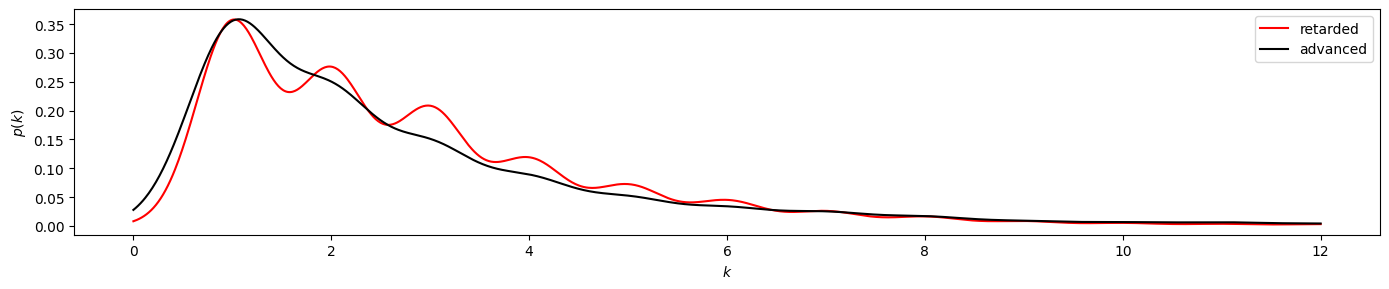

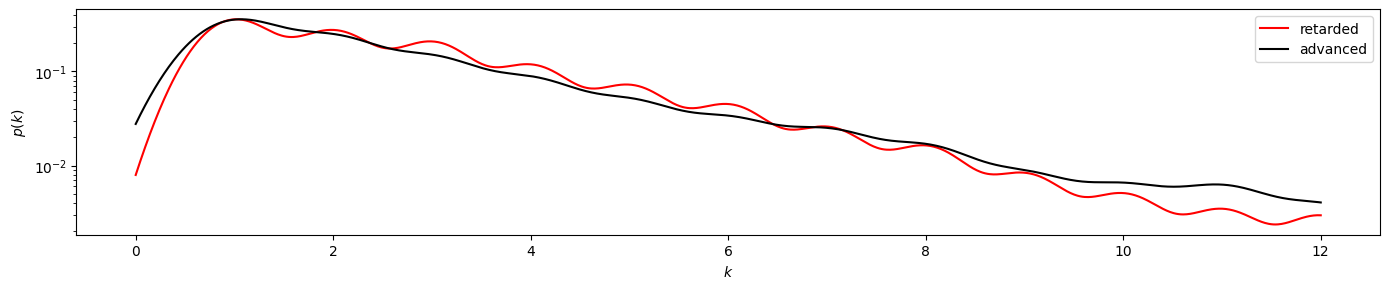

In [16]:
plot_time_directed(gkde_r2, gkde_a2)
plot_time_directed(gkde_r2, gkde_a2, ylog=True)

Here we find a stronger divergence between the retarded and advanced degree distributions, suggesting irreversibility of the underlying time series. And indeed, the KS test clearly yields `pvalue < 0.050`.

In [17]:
ks_2samp(k_r2, k_a2)

KstestResult(statistic=0.0593881223755249, pvalue=4.3359432807261227e-08, statistic_location=1.0, statistic_sign=-1)